# Assignment #

## Data Preparation ##

### Import Libraries and Load data ###

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import cv2
import ast

from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load Excel file
raw_data = pd.read_excel('C:\\Users\\s2760122\\Documents\\PythonScripts\\DS_Assignment\\height_and_pose.xlsx')
# raw_data

In [3]:
# Explore the dataset

raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Depthmap Image  9 non-null      object 
 1   Height(cm)      9 non-null      float64
 2   Pose            9 non-null      object 
dtypes: float64(1), object(2)
memory usage: 344.0+ bytes


In [4]:
raw_data['Pose'][0]

"[{'bbox_coordinates': [(158.91087, 92.53168), (396.85934, 616.8171)], 'bbox_confidence_score': [0.99280316], 'key_points_coordinate': [{'nose': {'x': 265.9385, 'y': 182.3019}}, {'left_eye': {'x': 289.8317, 'y': 168.64862}}, {'right_eye': {'x': 245.45859, 'y': 165.2353}}, {'left_ear': {'x': 317.13824, 'y': 178.88858}}, {'right_ear': {'x': 221.56538, 'y': 172.06195}}, {'left_shoulder': {'x': 334.20483, 'y': 233.50165}}, {'right_shoulder': {'x': 221.56538, 'y': 243.7416}}, {'left_elbow': {'x': 378.57794, 'y': 284.7014}}, {'right_elbow': {'x': 194.25885, 'y': 308.5946}}, {'left_wrist': {'x': 358.09805, 'y': 342.72778}}, {'right_wrist': {'x': 235.21864, 'y': 315.42123}}, {'left_hip': {'x': 341.03146, 'y': 393.92752}}, {'right_hip': {'x': 269.3518, 'y': 404.16748}}, {'left_knee': {'x': 354.68472, 'y': 506.56696}}, {'right_knee': {'x': 231.80533, 'y': 486.08707}}, {'left_ankle': {'x': 313.7249, 'y': 489.50037}}, {'right_ankle': {'x': 214.73874, 'y': 547.52673}}], 'key_points_prob': [{'nose':

- This is a string which seems to be a list of dictionaries having multiple key value pairs
- 'ast' module from python can be used to parse a string representation of a python object and convert it back into the corresponding Python object.

In [5]:
# Create a temporary Dataframe for data preparation

temp_df = pd.DataFrame(columns=['Depthmap Image','Height','bbox','key_points_coordinate','nose','left_eye','right_eye',
                               'left_ear','right_ear','left_shoulder','right_shoulder','left_elbow','right_elbow','left_wrist'
                                ,'right_wrist','left_hip','right_hip','left_knee','right_knee','left_ankle','right_ankle'
                                ,'nose_score','left_eye_score','right_eye_score',
                               'left_ear_score','right_ear_score','left_shoulder_score','right_shoulder_score','left_elbow_score'
                                ,'right_elbow_score','left_wrist_score'
                                ,'right_wrist_score','left_hip_score','right_hip_score','left_knee_score','right_knee_score'
                                ,'left_ankle_score','right_ankle_score','body_pose_score'
                               ,'key_points_prob','bbox_width', 'bbox_height'])

temp_df['Depthmap Image'] = raw_data['Depthmap Image']
temp_df['Height'] = raw_data['Height(cm)']

# Extract bbox details and keypoints' scores from 'Pose' and create separate columns in df

for i in range(len(raw_data)):
    list_of_dicts = ast.literal_eval(raw_data['Pose'][i])                  # convert the string to a list of dictionaries
    
    for dictionary in list_of_dicts:
        temp_df['bbox'].loc[i] = dictionary.get('bbox_coordinates')
        temp_df['key_points_coordinate'].loc[i] = dictionary.get('key_points_coordinate')
        temp_df['body_pose_score'].loc[i] = dictionary.get('body_pose_score')
        temp_df['key_points_prob'].loc[i] = dictionary.get('key_points_prob')
        


In [6]:
# Get each pose keypoints' coordinates separately and have it in a separate column

for i in range(len(raw_data)):
    for k in range(17):
        kp = temp_df['key_points_coordinate'][i][k]
        for key,value in kp.items():
            temp_df[key].loc[i] = kp[key]['x'],kp[key]['y']
            
del temp_df['key_points_coordinate']

# Get each key points' probability separately and have it in a separate column

for i in range(len(raw_data)):
    for k in range(17):
        kp = temp_df['key_points_prob'][i][k]
        for key,value in kp.items():
            temp_df[key+'_score'].loc[i] = kp[key]['score']
            
del temp_df['key_points_prob']

In [7]:
temp_df

,Depthmap Image,Height,bbox,nose,left_eye,right_eye,left_ear,right_ear,left_shoulder,right_shoulder,...,right_wrist_score,left_hip_score,right_hip_score,left_knee_score,right_knee_score,left_ankle_score,right_ankle_score,body_pose_score,bbox_width,bbox_height
0,1d5fee00-ada4-11eb-a80b-3f50af21830f,76.7,"[(158.91087, 92.53168), (396.85934, 616.8171)]","(265.9385, 182.3019)","(289.8317, 168.64862)","(245.45859, 165.2353)","(317.13824, 178.88858)","(221.56538, 172.06195)","(334.20483, 233.50165)","(221.56538, 243.7416)",...,0.933879,0.907734,0.886999,0.788052,0.945641,0.866014,0.955319,0.932521,NaN,NaN
1,1eddf4c0-ad9f-11eb-a80b-ef4adba049aa,66.4,"[(131.00702, 68.115364), (420.1891, 559.3997)]","(305.9835, 200.21199)","(197.23564, 152.235)","(305.9835, 181.0212)","(216.42644, 177.82274)","(286.7927, 197.01353)","(210.0295, 219.40279)","(305.9835, 228.99818)",...,0.934457,0.851971,0.940192,0.926724,0.954467,0.929338,0.997787,0.778794,NaN,NaN
2,38e29bc0-8fc0-11eb-b5f2-0742da91b282,63.2,"[(116.070114, 37.567608), (395.045, 542.00757)]","(191.51735, 123.93983)","(201.36969, 123.93983)","(299.89313, 137.0763)","(198.08557, 150.21274)","(299.89313, 140.3604)","(201.36969, 196.19034)","(296.609, 202.75858)",...,0.96517,0.87688,0.855791,0.946061,0.964368,0.939034,0.955803,0.877052,NaN,NaN
3,6cd5d480-8b8b-11eb-b152-f7b115384fa9,87.1,"[(145.24242, 26.49348), (346.4439, 637.2346)]","(239.8789, 142.99553)","(263.73596, 127.090805)","(223.97418, 127.090805)","(295.5454, 135.04317)","(208.06947, 135.04317)","(311.45013, 202.63821)","(204.09329, 194.68585)",...,0.969037,0.909324,0.926732,0.948325,0.967767,0.967155,0.990699,0.955477,NaN,NaN
4,76ed6fc0-8e1d-11eb-ad70-7be1a1219834,59.1,"[(150.17046, 65.00379), (373.36887, 611.4233)]","(167.49805, 155.00647)","(171.05548, 151.44904)","(174.61288, 151.44904)","(213.7445, 169.23615)","(295.56512, 147.89163)","(195.9574, 219.04001)","(309.7948, 176.35098)",...,0.931735,0.890535,0.890383,0.94432,0.969072,0.969516,0.94113,0.85383,NaN,NaN
5,8d23fa60-9201-11eb-b3e6-cbfb48c6a300,86.4,"[(146.97789, 37.342777), (323.04355, 616.20996)]","(304.73105, 143.99603)","(300.96237, 128.92137)","(293.42505, 128.92137)","(233.12637, 136.45871)","(236.89505, 140.22737)","(191.67105, 200.52603)","(263.2757, 211.83203)",...,0.936982,0.832527,0.797001,0.927706,0.956582,0.908808,0.891262,0.908704,NaN,NaN
6,9dc3eba0-8d8d-11eb-8d3f-4776be867c61,100.6,"[(135.09724, 42.205784), (308.40625, 609.4822)]","(212.51872, 161.49629)","(227.29155, 143.03027)","(194.05269, 143.03027)","(256.8372, 139.33707)","(171.89346, 139.33707)","(271.61002, 216.8944)","(160.81384, 220.5876)",...,0.954557,0.916506,0.891225,0.967009,0.975727,0.992385,0.956129,0.960757,NaN,NaN
7,9dd020a0-8d8d-11eb-8d3f-bfd9f6bd04d4,106.1,"[(167.52087, 52.946323), (322.8788, 583.97754)]","(222.72783, 157.70052)","(240.01399, 136.9571)","(208.89888, 140.41435)","(267.67188, 143.87158)","(195.06995, 150.78606)","(291.8725, 209.55904)","(191.61272, 209.55904)",...,0.964533,0.899878,0.898619,0.977678,1.007519,0.968692,0.984565,0.961107,NaN,NaN
8,d3757800-8dff-11eb-a328-472d4f8db277,99.9,"[(92.025406, 19.148962), (295.21625, 625.0551)]","(235.04018, 126.83931)","(235.04018, 118.949905)","(242.92958, 111.0605)","(148.25676, 115.0052)","(235.04018, 111.0605)","(120.643845, 189.95453)","(254.76369, 193.89923)",...,0.978555,0.87289,0.899166,0.974533,0.962666,0.92356,0.942727,0.915556,NaN,NaN


- Compute depth values for each keypoints
- Compute distance between important keypoints and use it as features(upper body length and lower body length proportions)
- From bounding box coordinates compute height and width of the bounding box, which will be used as features. 

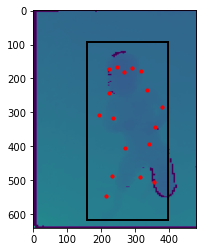

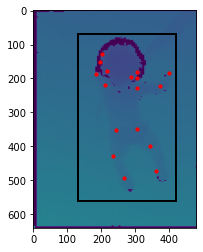

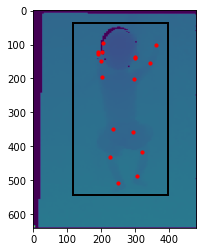

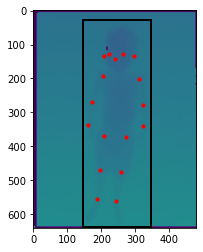

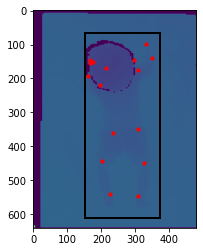

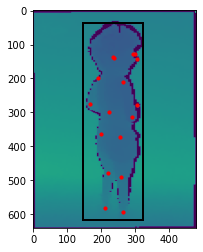

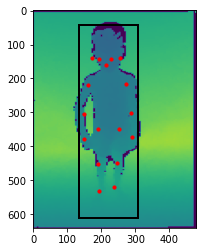

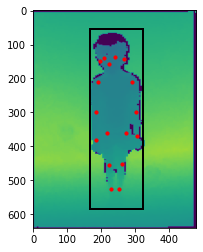

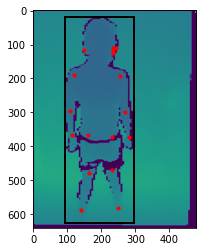

In [8]:
# Find bounding box width and height
include_column = ['nose', 'left_eye', 'right_eye',
       'left_ear', 'right_ear', 'left_shoulder', 'right_shoulder',
       'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist', 'left_hip',
       'right_hip', 'left_knee', 'right_knee', 'left_ankle', 'right_ankle']

for i in range(len(temp_df)):
    keypoint_array = []
    for j in range(temp_df.columns.size):
        if temp_df.columns[j] == 'Depthmap Image':
            img_name = temp_df.loc[i].values[j]
            depth_image = cv2.imread('C:\\Users\\s2760122\\Documents\\PythonScripts\\DS_Assignment\\depthmap\\'+ img_name +'.jpg', cv2.IMREAD_ANYDEPTH)
        
        if temp_df.columns[j] in include_column:
            x_value = np.floor(temp_df.loc[i].values[j][0]).astype(int)
            y_value = np.floor(temp_df.loc[i].values[j][1]).astype(int)
            keypt_coordinate = [x_value,y_value] 
            keypoint_array.append([x_value,y_value])  
            
            temp_df.get(temp_df.columns[j])[i] = depth_image[y_value,x_value].astype(int)
                   
        if temp_df.columns[j] == 'bbox':
            bbox_x1 = temp_df.loc[i].values[j][0][0]
            bbox_y1 = temp_df.loc[i].values[j][0][1]
            bbox_x2 = temp_df.loc[i].values[j][1][0]
            bbox_y2 = temp_df.loc[i].values[j][1][1]
           
            width = bbox_x2-bbox_x1
            height =  bbox_y2-bbox_y1
            temp_df['bbox_width'][i] = width
            temp_df['bbox_height'][i] = height
    
        
# Plot the Image, Boundingbox and Keypoints

    fig,ax = plt.subplots()
    
    ax.imshow(depth_image)
    rect = Rectangle((bbox_x1,bbox_y1),width,height, linewidth=2,edgecolor='black', facecolor='none')
    ax.add_patch(rect)
    ax.scatter([kp[0] for kp in keypoint_array],[kp[1] for kp in keypoint_array] ,c='r',s=10)
    plt.show()
    
del temp_df['Depthmap Image']
del temp_df['bbox']

In [9]:
# Estimate upper bode and lower body proportions

from scipy.spatial import distance
temp_df['upper_left']=  ""
temp_df['lower_left1'] = " "
temp_df['lower_left2'] = ""
temp_df['upper_right'] = ""
temp_df['lower_right1'] = ""
temp_df['lower_right2'] = ""
for i in range(len(temp_df)):
    temp_df['upper_left'].loc[i] = distance.euclidean(temp_df.get(['left_shoulder']).values[i][0], temp_df.get(['left_hip']).values[i][0])
    temp_df['lower_left1'].loc[i] = distance.euclidean(temp_df.get(['left_hip']).values[i][0], temp_df.get(['left_knee']).values[i][0])
    temp_df['lower_left2'].loc[i] = distance.euclidean(temp_df.get(['left_knee']).values[i][0], temp_df.get(['left_ankle']).values[i][0])

    temp_df['upper_right'].loc[i] = distance.euclidean(temp_df.get(['right_shoulder']).values[i][0], temp_df.get(['right_hip']).values[i][0])
    temp_df['lower_right1'].loc[i] = distance.euclidean(temp_df.get(['right_hip']).values[i][0], temp_df.get(['right_knee']).values[i][0])
    temp_df['lower_right2'].loc[i] = distance.euclidean(temp_df.get(['right_knee']).values[i][0], temp_df.get(['right_ankle']).values[i][0])

In [10]:
temp_df

,Height,nose,left_eye,right_eye,left_ear,right_ear,left_shoulder,right_shoulder,left_elbow,right_elbow,...,right_ankle_score,body_pose_score,bbox_width,bbox_height,upper_left,lower_left1,lower_left2,upper_right,lower_right1,lower_right2
0,76.7,74,78,74,86,0,86,93,89,96,...,0.955319,0.932521,237.94847,524.28542,0.0,86.0,104.0,4.0,7.0,4.0
1,66.4,73,0,60,58,60,77,74,79,76,...,0.997787,0.778794,289.18208,491.284336,7.0,8.0,2.0,7.0,5.0,12.0
2,63.2,88,79,77,78,78,80,80,88,85,...,0.955803,0.877052,278.974886,504.439962,4.0,8.0,1.0,3.0,10.0,2.0
3,87.1,84,84,87,95,97,96,95,103,103,...,0.990699,0.955477,201.20148,610.74112,3.0,7.0,10.0,3.0,8.0,8.0
4,59.1,54,52,52,47,0,0,66,68,75,...,0.94113,0.85383,223.19841,546.41951,69.0,5.0,0.0,4.0,4.0,1.0
5,86.4,0,0,79,76,77,0,78,100,79,...,0.891262,0.908704,176.06566,578.867183,91.0,14.0,4.0,7.0,8.0,12.0
6,100.6,93,92,93,0,166,105,106,118,0,...,0.956129,0.960757,173.30901,567.276416,2.0,39.0,4.0,5.0,27.0,9.0
7,106.1,103,104,103,115,5,113,114,123,119,...,0.984565,0.961107,155.35793,531.031217,10.0,19.0,17.0,9.0,13.0,22.0
8,99.9,1,0,0,97,0,87,86,97,92,...,0.942727,0.915556,203.190844,605.906138,10.0,12.0,4.0,14.0,11.0,11.0


In [11]:
for col in temp_df.columns:
    if temp_df[col].dtype=='object':
        temp_df[col] = pd.to_numeric(temp_df[col],errors='coerce')
        temp_df[col] = temp_df[col].astype('float')

## Data analysis and Preprocessing ##

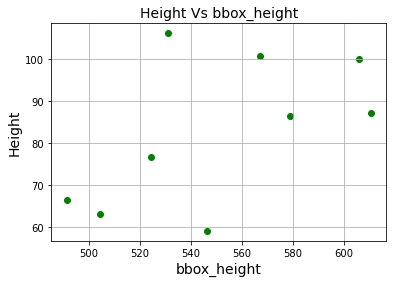

In [12]:
#Checking for linearity

plt.scatter(temp_df['bbox_height'], temp_df['Height'], color='green')
plt.title('Height Vs bbox_height', fontsize=14)
plt.xlabel('bbox_height', fontsize=14)
plt.ylabel('Height', fontsize=14)
plt.grid(True)
plt.show()

### Removing unwanted columns ###
- Based on the high level analysis, we can remove the score columns. And, since we use bounding box height and width values, we can remove bbox_coordinate column also.
- We create the final_df with the required columns.

In [13]:
temp_df.describe()

,Height,nose,left_eye,right_eye,left_ear,right_ear,left_shoulder,right_shoulder,left_elbow,right_elbow,...,right_ankle_score,body_pose_score,bbox_width,bbox_height,upper_left,lower_left1,lower_left2,upper_right,lower_right1,lower_right2
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.0,9.000000,9.000000,...,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
mean,82.833333,63.333333,54.333333,69.444444,72.444444,53.666667,71.555556,88.0,96.111111,80.555556,...,0.957269,0.904866,215.380974,551.139034,21.777778,22.000000,16.222222,6.222222,10.333333,9.000000
std,17.448496,38.209946,43.005814,30.360793,34.011436,57.751623,42.163702,15.5,17.553094,33.380800,...,0.032289,0.060223,46.542132,42.562032,33.636951,26.134269,33.334583,3.562926,6.855655,6.422616
min,59.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,66.0,68.000000,0.000000,...,0.891262,0.778794,155.357930,491.284336,0.000000,5.000000,0.000000,3.000000,4.000000,1.000000
25%,66.400000,54.000000,0.000000,60.000000,58.000000,0.000000,77.000000,78.0,88.000000,76.000000,...,0.942727,0.877052,176.065660,524.285420,3.000000,8.000000,2.000000,4.000000,7.000000,4.000000
50%,86.400000,74.000000,78.000000,77.000000,78.000000,60.000000,86.000000,86.0,97.000000,85.000000,...,0.955803,0.915556,203.190844,546.419510,7.000000,12.000000,4.000000,5.000000,8.000000,9.000000
75%,99.900000,88.000000,84.000000,87.000000,95.000000,78.000000,96.000000,95.0,103.000000,96.000000,...,0.984565,0.955477,237.948470,578.867183,10.000000,19.000000,10.000000,7.000000,11.000000,12.000000
max,106.100000,103.000000,104.000000,103.000000,115.000000,166.000000,113.000000,114.0,123.000000,119.000000,...,0.997787,0.961107,289.182080,610.741120,91.000000,86.000000,104.000000,14.000000,27.000000,22.000000


In [14]:
final_df = temp_df[['Height','left_shoulder', 'right_shoulder',
        'left_hip','right_hip', 'left_knee', 'right_knee', 'left_ankle', 'right_ankle','upper_left','lower_left1','lower_left2','upper_right','lower_right1','lower_right2',
                    'bbox_width', 'bbox_height']]

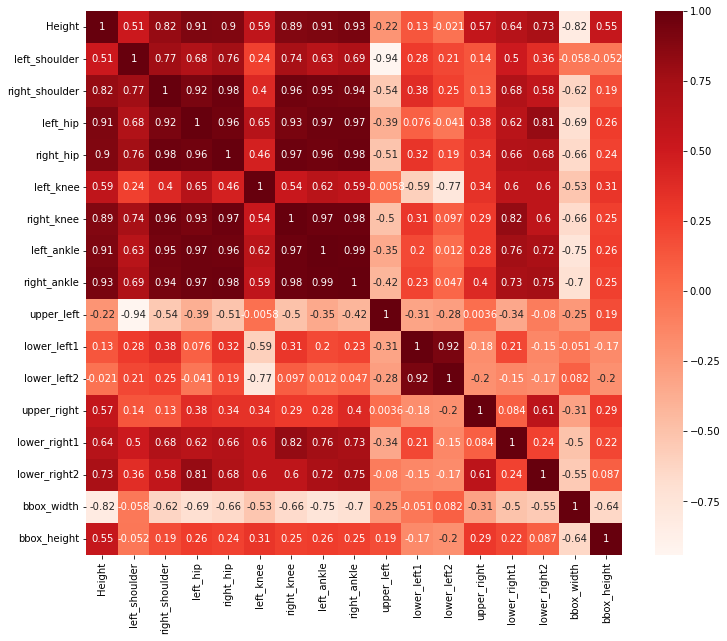

In [15]:
# Correlation analysis

%matplotlib inline
plt.figure(figsize=(12,10))
cor = final_df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

### Train-test split ###

In [16]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(final_df, train_size = 0.70, test_size = 0.30, random_state=20)

In [17]:
# Separate target from Feature matrix

X_train = train_df.drop("Height",1)   #Feature Matrix
Y_train= train_df["Height"]          #Target Variable
X_test = test_df.drop("Height",1)   #Feature Matrix
Y_test= test_df["Height"]          #Target Variable

### Feature Selection ###

In [18]:
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [19]:

Model = LinearRegression()

rfe = RFE(Model,n_features_to_select=10)             

rfe = rfe.fit(X_train, Y_train)

In [20]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('left_shoulder', True, 1),
 ('right_shoulder', False, 5),
 ('left_hip', True, 1),
 ('right_hip', False, 4),
 ('left_knee', False, 3),
 ('right_knee', True, 1),
 ('left_ankle', True, 1),
 ('right_ankle', True, 1),
 ('upper_left', False, 7),
 ('lower_left1', False, 6),
 ('lower_left2', False, 2),
 ('upper_right', True, 1),
 ('lower_right1', True, 1),
 ('lower_right2', True, 1),
 ('bbox_width', True, 1),
 ('bbox_height', True, 1)]

In [21]:
col = X_train.columns[rfe.support_]
col

Index(['left_shoulder', 'left_hip', 'right_knee', 'left_ankle', 'right_ankle',
       'upper_right', 'lower_right1', 'lower_right2', 'bbox_width',
       'bbox_height'],
      dtype='object')

In [22]:
X_train.columns[~rfe.support_]

Index(['right_shoulder', 'right_hip', 'left_knee', 'upper_left', 'lower_left1',
       'lower_left2'],
      dtype='object')

In [23]:
X_train_rfe = X_train[col]

X_test_rfe = X_test[col]

Model.fit(X_train_rfe,Y_train)

print("score: ",Model.score(X_train_rfe,Y_train))
print("Model slope:    ", Model.coef_)
print("Model intercept:", Model.intercept_)

score:  1.0
Model slope:     [ 0.14944006 -0.09663332 -0.01390983 -0.03880734  0.3307517   0.08228074
 -0.1906719   0.17770115 -0.14894144  0.03192188]
Model intercept: 60.9190080898652


### Prediction ###

In [24]:
# Predicting the Test set results
y_pred = Model.predict(X_test_rfe)
print("score: ",Model.score(X_test_rfe,Y_test))
print("Model slope:    ", Model.coef_)
print("Model intercept:", Model.intercept_)

score:  -1.117275485896052
Model slope:     [ 0.14944006 -0.09663332 -0.01390983 -0.03880734  0.3307517   0.08228074
 -0.1906719   0.17770115 -0.14894144  0.03192188]
Model intercept: 60.9190080898652
